# XGBOOST: Predicción de Readmisión Temprana (<30 días)
- Trabajaremos con el dataset diabetic_data.csv.

- Nuevo Objetivo: Predecir específicamente si un paciente será readmitido en menos de 30 días (clase 1).

- Los pacientes que no son readmitidos o que lo son después de 30 días se considerarán clase 0.

- Esto nos ayuda a identificar los casos más urgentes.

In [1]:
# Importo librerias que se utilizaran
import pandas as pd
import seaborn as sns

# Configuración de estilo de seaborn
sns.set_style("whitegrid")

# Carga de datos
data = pd.read_csv('../data/raw/diabetic_data.csv')

data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [2]:
# Primero eliminaré las filas identificatorias, en este caso son las siguientes: encounter_id, patient_nbr, payer code
import numpy as np
data.drop(['payer_code', 'encounter_id', 'patient_nbr'], axis=1, inplace=True)
data.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),?,6,25,1,1,Pediatrics-Endocrinology,41,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),?,1,1,7,3,?,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),?,1,1,7,2,?,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),?,1,1,7,1,?,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
# Ahora detecto que el data set tiene nulos en forma de ' ? ', creare un arreglo para eliminarlos, ya que son nulos
data.isnull().sum()

race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide   

In [4]:
import numpy as np

data.replace('?', np.nan, inplace=True)
print("Total de valores nulos: ")
data.isnull().sum()

Total de valores nulos: 


race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide   

Antes de eliminar los valores nulos, primero analizare su importancia para valorar su respectivo manejo.
Primero analizaré las columnas con más nulos:
- **weight (Peso) :** Contiene 98569 esto es mas del 90% de sus valores totales, es decir el total de filas (pacientes) es de 101,7666, por lo que procedere a eliminar la columna directamente, ya que un porcentaje tan alto no es posible rellenar valores, esto nos daria mas ruido.
- **payer_code (Codigo de pagador):** Contiene 40256 valores nulos, debido a la naturaleza de la variable el codigo de pagador no es relevante para predecir la readmisión, aparte considerando sus valores nulos no nos servira para entrenar el modelo, procedere a elimianarla.


In [5]:
# Elimino las columnas que poseen la mayor cantidad de nulos, en este caso weight ya que payer code lo eliminamos anteriormente
data.drop(['weight'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      99493 non-null   object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   admission_type_id         101766 non-null  int64 
 4   discharge_disposition_id  101766 non-null  int64 
 5   admission_source_id       101766 non-null  int64 
 6   time_in_hospital          101766 non-null  int64 
 7   medical_specialty         51817 non-null   object
 8   num_lab_procedures        101766 non-null  int64 
 9   num_procedures            101766 non-null  int64 
 10  num_medications           101766 non-null  int64 
 11  number_outpatient         101766 non-null  int64 
 12  number_emergency          101766 non-null  int64 
 13  number_inpatient          101766 non-null  int64 
 14  diag

- Pasamos de 101,766 filas a 99,139 filas. Perdimos 2,627 filas, lo cual es solo el 2.6% del total. al ser un porcentaje tan pequeño, no es tan relevante.
- Pasamos de 50 a 43 columnas.

- Ahora muestra 99,139 "Non-Null Count" para todas las columnas, y el chequeo final confirma 0 nulos.

In [6]:
data.duplicated().sum()

np.int64(0)

El data set no contiene valores duplicados.

### Analisis de variable objetivo
- El objetivo es entender la distrbución de la variable objetivo readdmited

In [7]:
data['readmitted'].value_counts()

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

C:\Users\asjer\AppData\Local\Temp\ipykernel_17988\2607853986.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data['readmitted'], color='blue', palette='viridis')


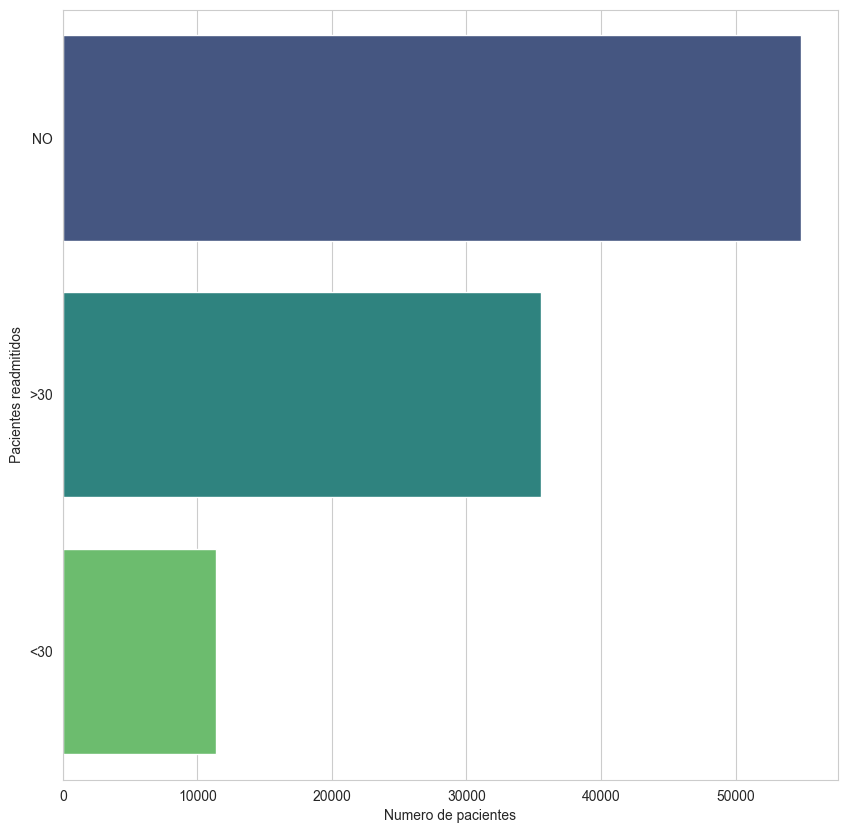

Porcentajes de cada variable: readmitted
NO     53.911916
>30    34.928169
<30    11.159916
Name: proportion, dtype: float64


In [8]:
# Graficaré para tener una representación visual de la distribución.
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid") # Tema para todos los graficos.
plt.figure(figsize=(10,10))
sns.countplot(data['readmitted'], color='blue', palette='viridis')
plt.xlabel('Numero de pacientes')
plt.ylabel('Pacientes readmitidos')
plt.show()

readmitted_norm = data['readmitted'].value_counts(normalize=True)
print(f"Porcentajes de cada variable: {readmitted_norm*100}")

Se puede observar una distribución desbalanceada, con un sesgo hacia los pacientes que no fueron readmitidos.
- mayor 30:  esta variable la manejaremos como pacientes que no fueron readmitidos y representa el 35.3%.
- NO: Pacientes que no fueron readmitidos y representa el 53.3%.
- Menor a 30: Aquellos que fueron readmitidos y representa el 11.2%.

- Para este analisis voy a optar por una clasificacion binaria, simplificando las variables mayor a 30 y NO como pacientes que no fueron readmitido, de esta manera la clase minoritaria es los pacientes que fueron readmitdos.
- De este modo creare una nueva columna llamada target que sera la variable objetivo y la dividire en dos grupos:
- 1: Aquellos que fueron readmitidos (<30 )
- 0: Aquellos que no fueron readmitidos (>30) Dias y (NO)

In [9]:
mapping = {'<30': 1, '>30': 0, 'NO': 0}
data['target'] = data['readmitted'].map(mapping)

data['target'].value_counts()

target
0    90409
1    11357
Name: count, dtype: int64

- Pasaré las edades a numeros enteros ya que estan como rangos de edad, es decir 0-10, 10-20, etc.
- En este script voy a organizar las edades segun la media del rango de edad, de esta manera el modelo puede trabajar con enteros.


In [10]:
# Convertimos '[0-10)' en 5, '[10-20)' en 15, etc.
data['age'] = data['age'].str.strip()
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, 
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, 
    '[80-90)': 85, '[90-100)': 95
}
data['age'] = data['age'].map(age_mapping)

data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,target
0,Caucasian,Female,5,6,25,1,1,Pediatrics-Endocrinology,41,0,...,No,No,No,No,No,No,No,No,NO,0
1,Caucasian,Female,15,1,1,7,3,NaN,59,0,...,Up,No,No,No,No,No,Ch,Yes,>30,0
2,AfricanAmerican,Female,25,1,1,7,2,NaN,11,5,...,No,No,No,No,No,No,No,Yes,NO,0
3,Caucasian,Male,35,1,1,7,2,NaN,44,1,...,Up,No,No,No,No,No,Ch,Yes,NO,0
4,Caucasian,Male,45,1,1,7,1,NaN,51,0,...,Steady,No,No,No,No,No,Ch,Yes,NO,0


**Mapeo de Medicamentos (Ordinalidad)**
- Razón: Convertir texto a números con orden lógico.

- Justificación: No es lo mismo que un paciente mantenga su dosis a que se la suban (indica descontrol). Usar 0, 1, 2, 3 preserva esa jerarquía de información clínica que OneHotEncoding perdería (o complicaría con demasiadas columnas).

In [11]:

# Capturamos la intensidad del tratamiento
med_mapping = {'No': 0, 'Steady': 1, 'Down': 2, 'Up': 3}
med_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 
            'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 
            'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 
            'miglitol', 'troglitazone', 'tolazamide', 'examide', 
            'citoglipton', 'insulin', 'glyburide-metformin', 
            'glipizide-metformin', 'glimepiride-pioglitazone', 
            'metformin-rosiglitazone', 'metformin-pioglitazone']

# Aplicamos el mapeo
for col in med_cols:
    data[col] = data[col].map(med_mapping)


In [12]:
import pandas as pd
import numpy as np

def map_icd9_to_category(code):
    """
    Transforma códigos ICD-9 a categorías generales.
    Maneja códigos numéricos, alfanuméricos (V, E) y valores nulos (?).
    """
    if code == '?' or pd.isna(code):
        return 'Other'
    
    try:
        # Si empieza con V o E, usualmente son factores suplementarios o externos
        if str(code).startswith('V') or str(code).startswith('E'):
            return 'Other'
        
        # Convertimos a float para manejar decimales
        code_num = float(code)
        
        # Rangos estándar de agrupación ICD-9
        if 390 <= code_num <= 459 or code_num == 785:
            return 'Circulatory'
        elif 460 <= code_num <= 519 or code_num == 786:
            return 'Respiratory'
        elif 520 <= code_num <= 579 or code_num == 787:
            return 'Digestive'
        elif 250 <= code_num < 251:
            return 'Diabetes'
        elif 800 <= code_num <= 999:
            return 'Injury'
        elif 710 <= code_num <= 739:
            return 'Musculoskeletal'
        elif 580 <= code_num <= 629 or code_num == 788:
            return 'Genitourinary'
        elif 140 <= code_num <= 239:
            return 'Neoplasms'
        else:
            return 'Other' # Incluye infecciosas, mentales, etc.
            
    except ValueError:
        return 'Other'

# Aplicamos la función a las 3 columnas de diagnóstico
diag_cols = ['diag_1', 'diag_2', 'diag_3']
for col in diag_cols:
    data[f'{col}_group'] = data[col].apply(map_icd9_to_category)

# Verificamos el resultado
print(data[['diag_1', 'diag_1_group']].head(15))

    diag_1 diag_1_group
0   250.83     Diabetes
1      276        Other
2      648        Other
3        8        Other
4      197    Neoplasms
5      414  Circulatory
6      414  Circulatory
7      428  Circulatory
8      398  Circulatory
9      434  Circulatory
10   250.7     Diabetes
11     157    Neoplasms
12     428  Circulatory
13     428  Circulatory
14     518  Respiratory


In [13]:
data['target']

0         0
1         0
2         0
3         0
4         0
         ..
101761    0
101762    0
101763    0
101764    0
101765    0
Name: target, Length: 101766, dtype: int64

In [14]:
# Convertir variables categoricas (One Hot Encoding)
data_dummies = pd.get_dummies(data, drop_first=True)
print(f"Dimensiones finales: {data.shape}")

Dimensiones finales: (101766, 50)


In [15]:
data_dummies['target']

0         0
1         0
2         0
3         0
4         0
         ..
101761    0
101762    0
101763    0
101764    0
101765    0
Name: target, Length: 101766, dtype: int64

### Analisis multivariante
- Analisis de corrlecaciones

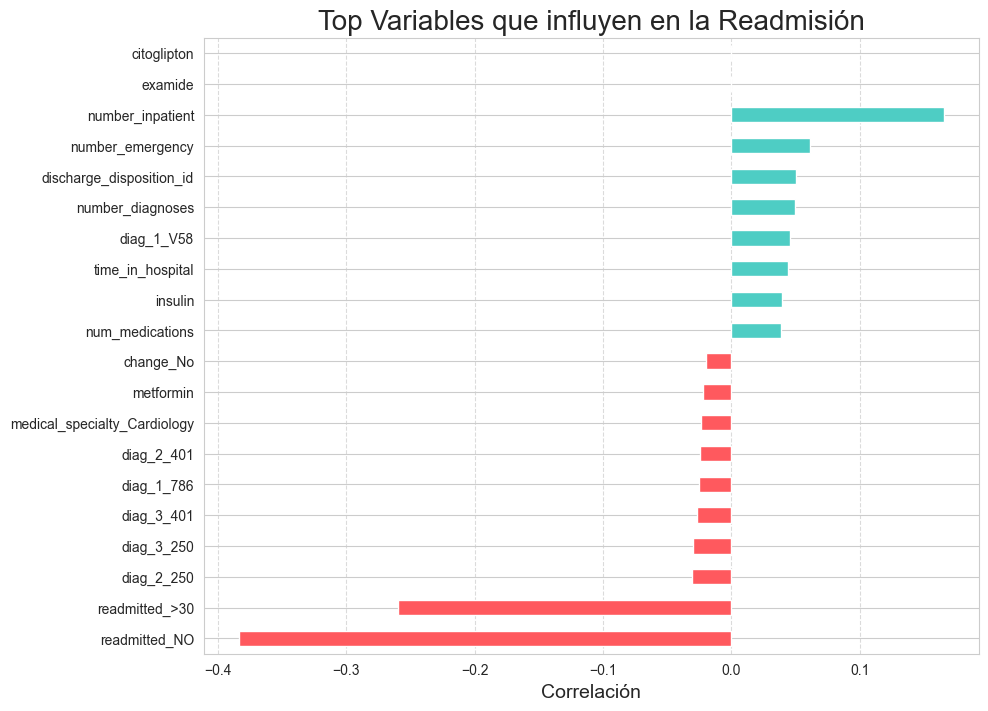

In [16]:
#Top Correlaciones con el Target
plt.figure(figsize=(10, 8))
# Calculamos correlación de todas las vars contra 'target'
correlations = data_dummies.corr()['target'].drop('target').sort_values()

# Mostramos las más negativas y las más positivas
top_corr = pd.concat([correlations.head(10), correlations.tail(10)])

top_corr.plot(kind='barh', color=['#ff595e']*10 + ['#4ecdc4']*10) # Colores custom para diferenciar
plt.title('Top Variables que influyen en la Readmisión', fontsize=20)
plt.xlabel('Correlación', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [17]:
from sklearn.model_selection import train_test_split

X = data_dummies.drop("target", axis=1)
y = data_dummies["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Como tenemos muchas columnas por el One-Hot Encoding, un mapa de calor gigante se vería horrible. Mejor filtremos y veamos solo el Top 10 de variables que más correlacionan con la readmisión.

In [18]:
# Instala optuna si no lo tienes
# !pip install optuna

import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

def objective(trial):
    # Espacio de búsqueda de hiperparámetros
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        # scale_pos_weight es CRÍTICO para clases desbalanceadas
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10)
    }
    
    # Instanciar modelo con los params sugeridos
    model = XGBClassifier(
        **params,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )
    
    # Entrenar
    model.fit(X_train, y_train)
    
    # Predecir probabilidades para AUC
    preds = model.predict_proba(X_test)[:, 1]
    
    # Optimizamos AUC porque nos importa rankear bien a los positivos
    auc = roc_auc_score(y_test, preds)
    return auc

# Ejecutamos la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20) # Ponle 50 o 100 si tienes tiempo y buen PC

print("Mejores hiperparámetros:", study.best_params)
print("Mejor AUC:", study.best_value)

[I 2025-11-20 14:25:14,888] A new study created in memory with name: no-name-2a832bfa-1f6d-4741-b554-265f6f1f3b9b
[W 2025-11-20 14:25:14,890] Trial 0 failed with parameters: {'n_estimators': 935, 'max_depth': 8, 'learning_rate': 0.1721719285284406, 'subsample': 0.997942070273844, 'colsample_bytree': 0.5275610666312973, 'scale_pos_weight': 6.131501951715321} because of the following error: NameError("name 'XGBClassifier' is not defined").
Traceback (most recent call last):
  File "c:\Users\asjer\AppData\Local\Programs\Python\Python313\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\asjer\AppData\Local\Temp\ipykernel_17988\2452927221.py", line 21, in objective
    model = XGBClassifier(
            ^^^^^^^^^^^^^
NameError: name 'XGBClassifier' is not defined
[W 2025-11-20 14:25:14,904] Trial 0 failed with value None.


NameError: name 'XGBClassifier' is not defined